##### File : emyers_final_project.ipynb
##### Edward Myers
##### Class : CS 677
##### Date: 4/23/23
##### Homework Problem: Final Project
##### Description of Problem: Create models that identify correlations between geographical census metrics and predict the availability of broadband services (metrics include income, health insurance percentage, poverty level, unemployment, etc).

## Project - Predicting U.S. Broadband Availability from Economic Census Data

### Project goals:
1. Visually analyze data to observe correlations and select appropriate model algorithms.
2. Compare data overall and using several predictive numeric models (K Nearest Neighbor, Logistic Regression, Gaussian Naive Bayes, etc.)
3. Execute training and testing of model classifiers and analyze confusion matrices to determine the most accurate algorithms.
4. Use the models to predict broadband availability in a specific example, my home county (Cumberland County, Pennsylvania).  

### Dataset:
- "US Broadband Availability" (https://www.kaggle.com/datasets/mmattson/us-broadband-availability)

### Background:
I work for my local government in central Pennsylvania, and finding gaps in general services within our constituency is very useful as we have districts with varying degrees of financial distress.  Understanding the correlation between several 'basic needs' census categories and how they relate to broadband services has become prevalent with the recent Get Internet : Affordable Connectivity Program from President Biden's Administration.  As an extension of American Rescue Plan funding, local governments would benefit from gaining knowledge on where broadband services exist and where efforts could be supplemented.

## Preparing the Data

In [1]:
import numpy as np    
import pandas as pd

# import broadband access csv file into a dataframe
input_frame = pd.read_csv('broadband_access.csv')

### Data Overview:
The four leading columns are categorical information (full_name, county, state, state_abr).  The rest is quantitative data representing actual amounts or percentages of population.  A list of the column header explanations is located in the document "Column Explanations.txt". 

This data set comes from a combination of data sources compiled by the author:  
1. The Institute of Museum and Library Services (IMLS): that blended indicators about economic status from the U.S Census Bureau American Community Survey (ACS), FCC data from BroadbandNow.com (BBN), and local unemployment from the Bureau of Labor and Statistics (BLS). This data blends instantaneous data from 2019 and aggregate census data from 2014-2018.
2. An updated dataset from BroadbandNow.com: which contained parallel data regarding population and broadband availability at the time of sample (2020), adding numerous classifications for broadband data such as providers and speeds.

As a result of this data blending, several columns have similar or duplicate data from different data sets or time periods.

### Data Cleaning:
- Several of the categorical data columns are redundant, such as full_name and state_abr.  Those columns will be removed from the dataframe upon import.
- Several rows do not have data available (NULL or NaN).  As these will act as the variables which trains most of our models, rows with NaN entries will be removed.
- My class determiner is derived from the "access_bbn" data column for broadband availability.  I can remove extraneous columns from the BBN and ACS portions of my data.
- For clarity, the column names will be appended with their source data abbreviation.

In [2]:
# Perform cleaning as described above
# 1) eliminate entries where key columns show 'NaN'
# 2) eliminate 'full_name' and 'state_abr'
# 3) eliminate data irrelevant to independent/dependent variables

analyze = input_frame[["broad_avail", "unemp", "health_ins", "poverty", 
                           "SNAP", "access_bbn", "population_bbn"] ].dropna()

# rename data columns to append source data set names and improve
# clarity for upcoming duplicate data comparison.
analyze.rename( columns = {'unemp': 'unemp_imls', 
                               'health_ins': 'health_ins_imls', 
                               'poverty': 'poverty_imls', 
                               'SNAP': 'SNAP_imls', 
                               'broad_avail': 'broad_avail_imls', 
                               'broad_cost': 'broad_cost_imls'}, inplace = True )


In [3]:
analyze.head(10)

,broad_avail_imls,unemp_imls,health_ins_imls,poverty_imls,SNAP_imls,access_bbn,population_bbn
0,0.0,2.7,7.1,15.4,12.7,90.764671,55059.0
1,0.0,2.7,10.2,10.6,7.5,92.428766,180490.0
2,99.2,3.8,11.2,28.9,27.4,79.683691,24729.0
3,0.0,3.1,7.9,14.0,12.4,41.738078,23339.0
4,0.0,2.7,11.0,14.4,9.5,79.697642,44950.0
5,40.1,3.6,10.8,31.4,25.9,87.188122,11450.0
6,0.0,3.6,10.2,23.5,18.6,81.810537,18373.0
7,86.5,3.5,9.4,18.6,17.9,96.206339,114816.0
8,93.0,2.9,10.8,16.6,14.7,88.671780,34422.0
9,25.6,2.9,8.3,15.0,15.9,99.482502,25175.0


### Creating a Subset with Population Metrics:
The key quantitative factors that will be compared against broadband availability are:
1. population count
2. percentage without health insurance
3. percentage of poverty rate
4. percentage rate using the supplemental nutrition assistance program (SNAP)

Broadband availability in terms of the data set is measured in a percentage.  For the purposes of this project, the percentages will be transformed into a binary class label.  

In [4]:
print ('Broadband Availability : IMLS data ~2019')
analyze['broad_avail_imls'].describe()

Broadband Availability : IMLS data ~2019


count    3126.000000
mean       73.862252
std        24.697538
min         0.000000
25%        61.925000
50%        80.950000
75%        93.575000
max       100.000000
Name: broad_avail_imls, dtype: float64

In [5]:
print ('Broadband Availability : BBM data ~2020')
analyze['access_bbn'].describe()

Broadband Availability : BBM data ~2020


count    3126.000000
mean       83.734829
std        21.004328
min         0.000000
25%        77.261672
50%        91.984575
75%        98.516771
max       100.000000
Name: access_bbn, dtype: float64

Looking at the median behavior of the two columns related to broadband availability, the 2019 data shows a median of 81% while the 2020 data shows a median of 92%.  The binary class label created from either set should skew well towards broadband being available than not.  The 'access_bbn' column will be used as it contains more current data. From this column, a new column named 'access_new' will be populated with 1 if the percentage is above or equal to 50%, and 0 if the percentage is below 50%.

In [6]:
# preload new access column with zero
analyze['access_new'] = 0

# assign a 1 to the access column if the access_bbn value is >= 50%
analyze.loc[input_frame['access_bbn'] >= 50, 'access_new'] = 1 

analyze

,broad_avail_imls,unemp_imls,health_ins_imls,poverty_imls,SNAP_imls,access_bbn,population_bbn,access_new
0,0.0,2.7,7.1,15.4,12.7,90.764671,55059.0,1
1,0.0,2.7,10.2,10.6,7.5,92.428766,180490.0,1
2,99.2,3.8,11.2,28.9,27.4,79.683691,24729.0,1
3,0.0,3.1,7.9,14.0,12.4,41.738078,23339.0,0
4,0.0,2.7,11.0,14.4,9.5,79.697642,44950.0,1
...,...,...,...,...,...,...,...,...
3137,95.1,3.9,12.0,12.0,5.8,97.424425,42653.0,1
3138,96.0,2.7,10.0,7.1,2.1,96.205612,21205.0,1
3139,73.9,3.9,12.2,12.5,7.1,91.824942,21153.0,1
3140,86.1,3.9,15.4,12.4,4.9,90.318911,8598.0,1


### Creating Training and Testing Data
The analysis will split the training and testing data in a 30%/70% ratio.  The results will be stratified to ensure a fair and distributed sample.  A scaler will be used for all model classifiers regardless of whether it is needed or not for a particular algorithm to ensure an honest comparison of accuracies.  A random state seed will be set to make the results repeatable.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# create train and test data split from columns in dataframe
x_train, x_test, y_train, y_test = train_test_split (analyze[["unemp_imls",
                                                              "health_ins_imls",
                                                              "poverty_imls",
                                                              "SNAP_imls",
                                                              "population_bbn"]],
                                                    analyze["access_new"], 
                                                    test_size = 0.3, 
                                                    random_state = 1,
                                                    stratify = 
                                                    analyze["access_new"])
# fit & transform on x_train data
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)

# transform test data
x_test_sc = scaler.transform(x_test)

### Analyzing Data for Correlation
Next, a pair plot and correlation matrix will be used to identify strongly correlated variables.  If near-perfect correlations exist within a set of data columns, one or more of the duplicates can be omitted as they would not have a discernable impact on the model.  Efficiency would also be improved.

Text(0.5, 1.05, 'Pair Plot Analysis of Quantitative Data')

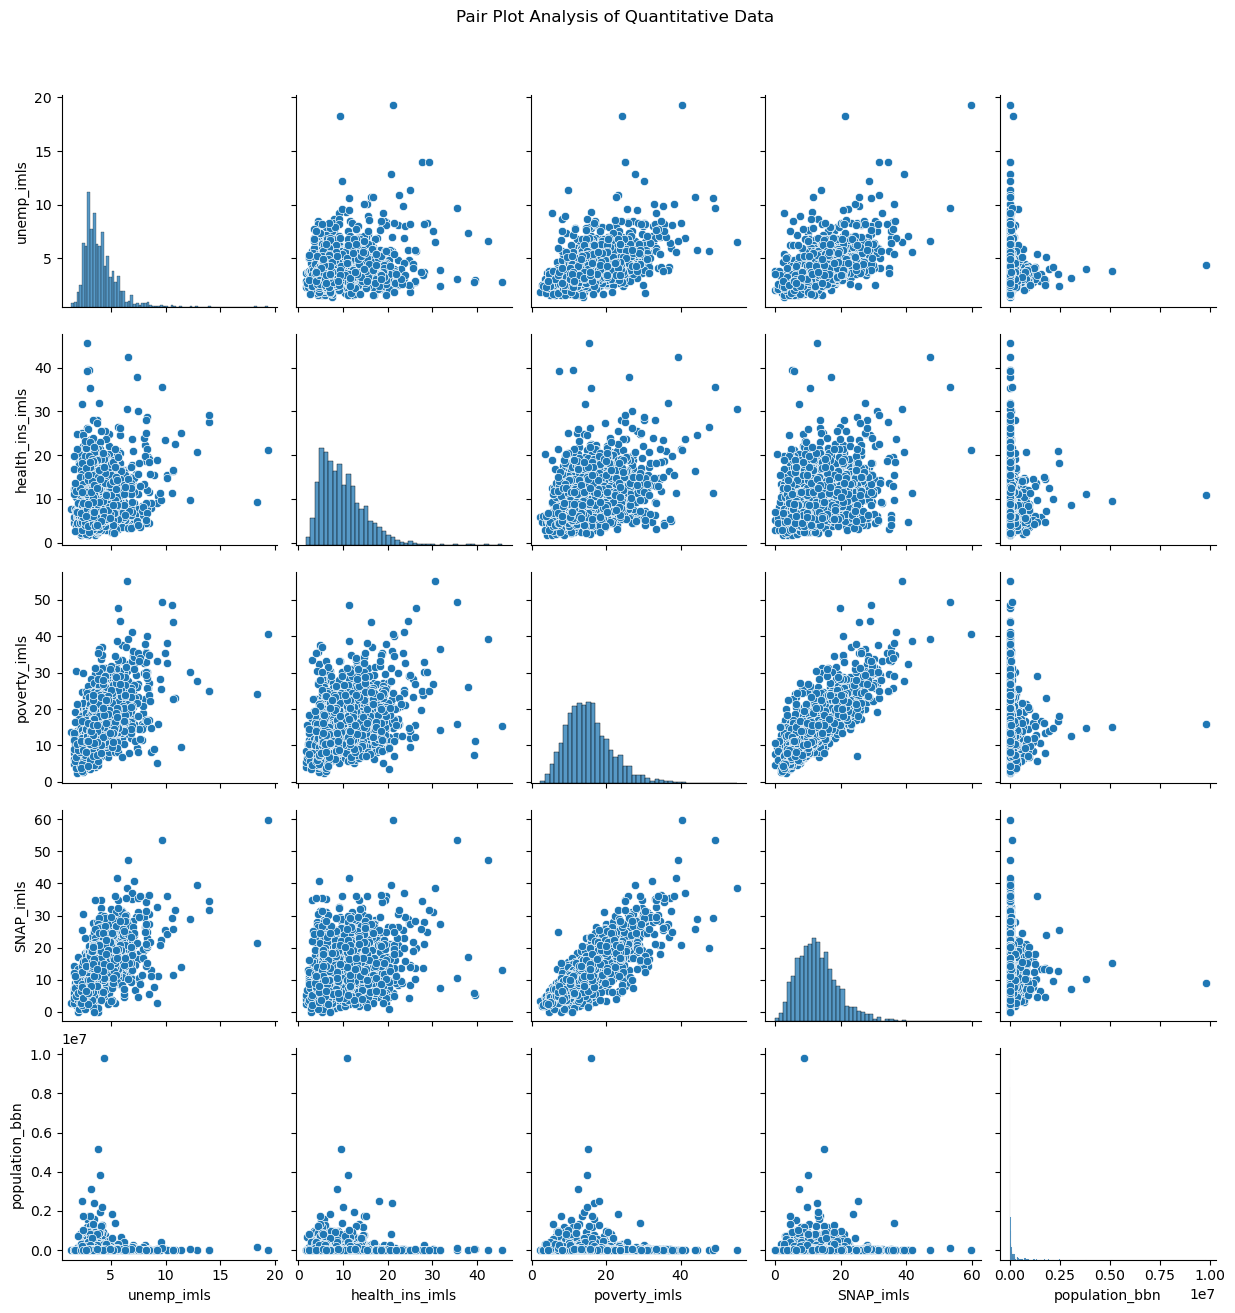

In [8]:
# import graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt

# create a pair plot demonstrating the relationships
sns.pairplot( x_train ).fig.suptitle(
    "Pair Plot Analysis of Quantitative Data", y=1.05)


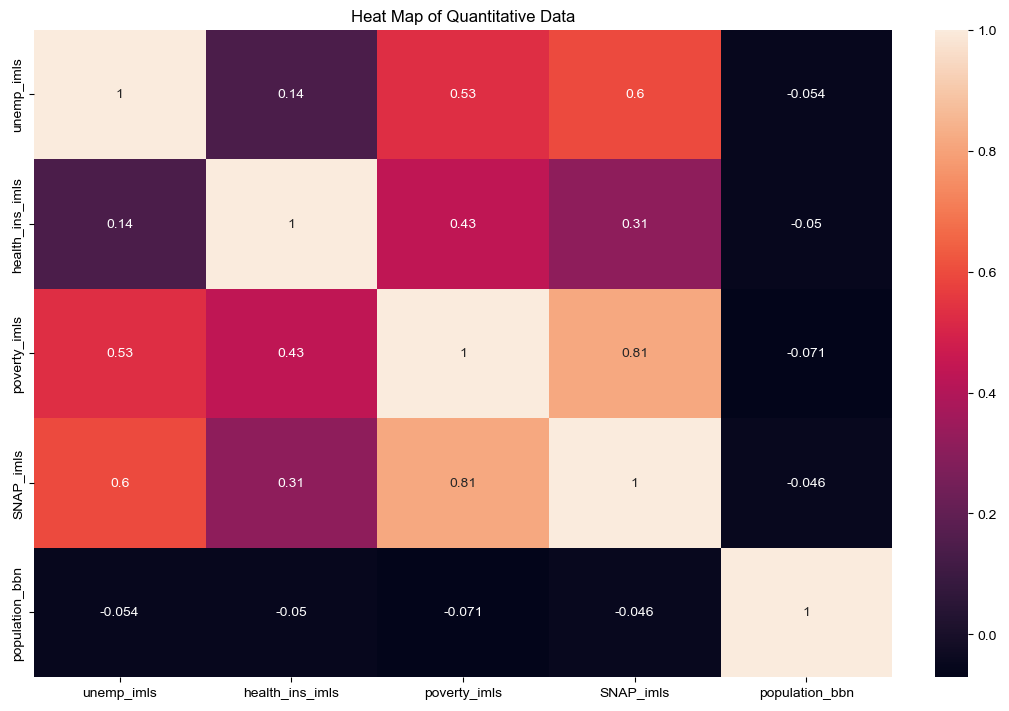

In [9]:
# set plot variables, title, etc.
plt.figure(figsize=(10, 7), layout='compressed')
ax = plt.axes()
ax.set_title("Heat Map of Quantitative Data")
ax.set(xlabel="", ylabel="")

# create heatmap, passing correlation matrix
sns.heatmap(x_train.corr(), annot=True, ax = ax)
sns.set(font_scale=1)
plt.show()


### Observations
- No two dependent variables share a near-perfect positive or negative correlation as to remove a duplicate from consideration
- Population demonstrates the weakest correlation to any other variable.
- The strongest correlation is between poverty rate and SNAP at 0.81.  

## Modeling the Data

### Selecting the Models
Factors:
- The data dependent variables are quantitative
- The independent variable is a binary class label

Therefore, the following models will be employed to analyze the results: 
- K Nearest Neighbor
- Logistic Regression
- Gaussian Naive Bayes
- Decision Tree
- Random Forest
- Support Vector Machines
- K-Means

### K Nearest Neighbor

#### Model Testing & Accuracy

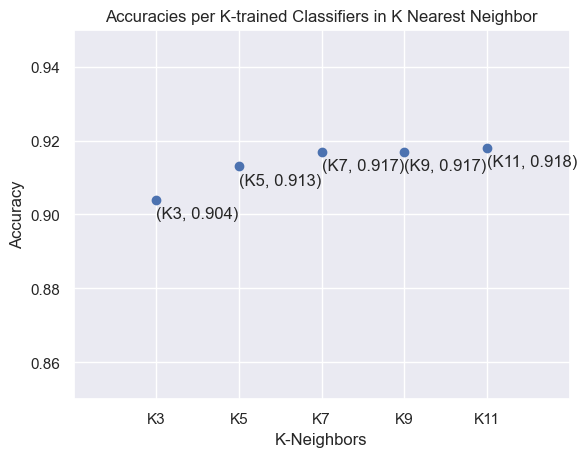

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

acc_list = []
for value in [3,5,7,9,11]:

    # set classifier and train
    knn_class = KNeighborsClassifier(n_neighbors = value)
    knn_class.fit (x_train_sc, y_train)

    # create prediction
    y_pred = knn_class.predict(x_test_sc)

    # calculate accuracy and add to accuracy list
    acc = round(accuracy_score(y_test, y_pred), 3)
    acc_list.append(acc)

# create x and y data for scatterplot
x = np.array(['K3', 'K5', 'K7', 'K9', 'K11'])
y = np.array(acc_list)

# plot data
plt.scatter(x, y)

# create coordinate outputs beside point
for i, j in zip(x, y):
   plt.text(i, j -.005, '({}, {})'.format(i, j))

# labels and titles
plt.title("Accuracies per K-trained Classifiers in K Nearest Neighbor")
plt.xlabel('K-Neighbors')
plt.ylabel('Accuracy')

# set boundaries and show
plt.axis([-1, 5, .85, .95])
plt.show()

All values of K are fairly accurate.  To balance overfitting vs high accuracy, K=5 is the best choice at .913 accuracy

#### Confusion Matrix

Overall Accuracy : 0.913
True Positives : 852
True Negatives : 4
False Positives : 73
False Negatives : 9


Text(74.45000000000006, 0.5, 'Predicted Labels')

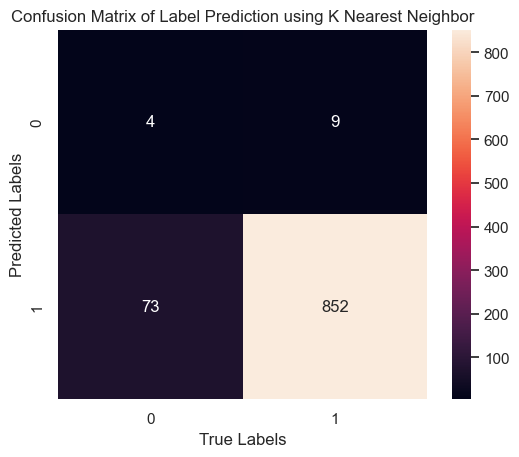

In [11]:
# using K = 5
knn_class = KNeighborsClassifier(n_neighbors = 5)
knn_class.fit (x_train_sc, y_train)

# create prediction
kn_y_pred = knn_class.predict(x_test_sc)

# calculate accuracy and print
kn_acc = round(accuracy_score(kn_y_pred, y_test), 3)

from sklearn.metrics import confusion_matrix

# plot the confusion matrix
kn_mat = confusion_matrix(y_test, kn_y_pred)
kn_tn, kn_fp, kn_fn, kn_tp = confusion_matrix(y_test, kn_y_pred).ravel()

print (f"Overall Accuracy : {kn_acc}")
print (f"True Positives : {kn_tp}")
print (f"True Negatives : {kn_tn}")
print (f"False Positives : {kn_fp}")
print (f"False Negatives : {kn_fn}")

# create a heatmap
sns.heatmap(kn_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using K Nearest Neighbor') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### Logistic Regression

#### Accuracy

In [12]:
# load logistic regression algorithm
from sklearn.linear_model import LogisticRegression

# perform logistic regression fit on training data
log_reg = LogisticRegression()
log_reg.fit(x_train_sc, y_train)

# predict values applying trained algorithm on test data
lr_y_pred = log_reg.predict(x_test_sc)

# overall accuracy from logistic regression above
lr_acc = round(accuracy_score(lr_y_pred, y_test), 3)
print (f"Accuracy using logistic regression on test data is : {lr_acc}")


Accuracy using logistic regression on test data is : 0.918


#### Confusion Matrix

Overall Accuracy : 0.918
True Positives : 858
True Negatives : 3
False Positives : 74
False Negatives : 3


Text(74.45000000000006, 0.5, 'Predicted Labels')

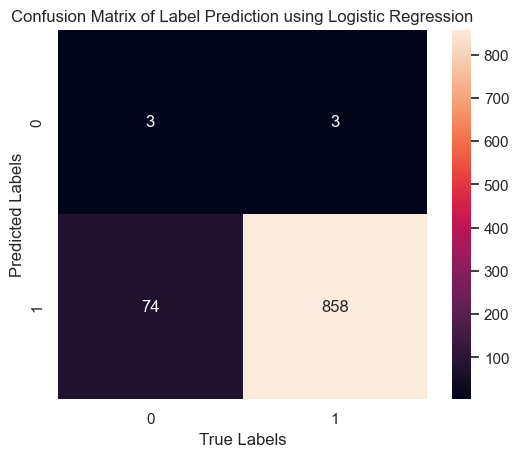

In [13]:
# plot the confusion matrix
lr_mat = confusion_matrix(y_test, lr_y_pred)
lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(y_test, lr_y_pred).ravel()

print (f"Overall Accuracy : {lr_acc}")
print (f"True Positives : {lr_tp}")
print (f"True Negatives : {lr_tn}")
print (f"False Positives : {lr_fp}")
print (f"False Negatives : {lr_fn}")

# create a heatmap
sns.heatmap(lr_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using Logistic Regression') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### Gaussian Naive Bayes

#### Accuracy

In [14]:
from sklearn.naive_bayes import GaussianNB

# create and fit a naive bayesian model to the training data
gnb_class = GaussianNB()
gnb_class.fit(x_train_sc, y_train)

# predict class values for x_test
nb_y_pred = gnb_class.predict(x_test_sc)

# overall accuracy from Gaussian Naive Bayes above
nb_acc = round(accuracy_score(nb_y_pred, y_test), 3)
print (f"Accuracy using logistic regression on test data is : {nb_acc}")


Accuracy using logistic regression on test data is : 0.763


#### Confusion Matrix

Overall Accuracy : 0.763
True Positives : 667
True Negatives : 49
False Positives : 28
False Negatives : 194


Text(74.45000000000006, 0.5, 'Predicted Labels')

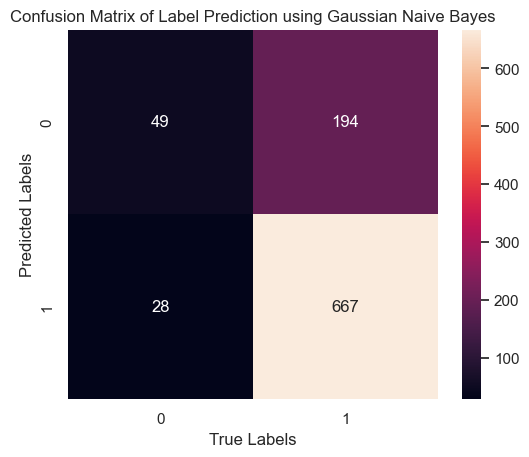

In [15]:
# plot the confusion matrix
nb_mat = confusion_matrix(y_test, nb_y_pred)
nb_tn, nb_fp, nb_fn, nb_tp = confusion_matrix(y_test, nb_y_pred).ravel()

print (f"Overall Accuracy : {nb_acc}")
print (f"True Positives : {nb_tp}")
print (f"True Negatives : {nb_tn}")
print (f"False Positives : {nb_fp}")
print (f"False Negatives : {nb_fn}")

# create a heatmap
sns.heatmap(nb_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using Gaussian Naive Bayes') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### Decision Tree

#### Model Testing & Accuracy

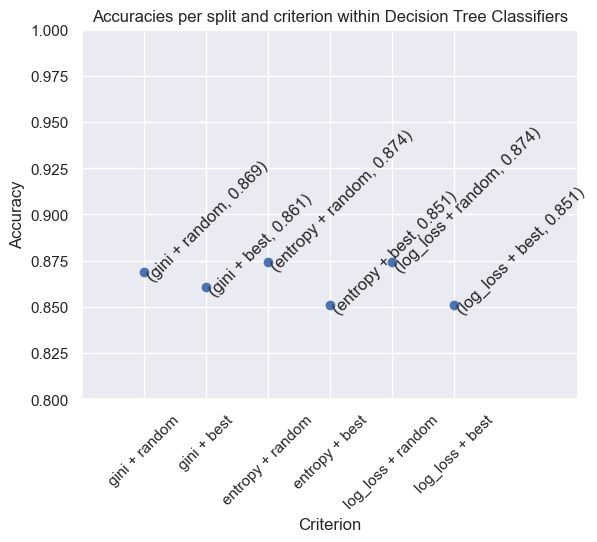

In [16]:
# create and fit a decision tree model to the training data
from sklearn import tree

# container for accuracies
acc_list = []

# containters for criterion and splitter to use as iteration
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['random', 'best']

# iterate through criterion
for value in criterion:
    # iterate through splitting strategies
    for split in splitter:

        # set classifier and train using variable criterion
        dt_model = tree.DecisionTreeClassifier (random_state = 1, 
                                                criterion = value,
                                                splitter = split)
        dt_model.fit(x_train_sc, y_train)

        # create prediction
        dt_y_pred = dt_model.predict(x_test_sc)

        # calculate accuracy and add to accuracy list
        acc = round(accuracy_score(y_test, dt_y_pred), 3)
        acc_list.append(acc)

# create x and y data for scatterplot
x = np.array(['gini + random', 'gini + best',
            'entropy + random', 'entropy + best', 
            'log_loss + random', 'log_loss + best'])
y = np.array(acc_list)

# plot data
plt.scatter(x, y)

# create coordinate outputs beside point
for i, j in zip(x, y):
   plt.text(i, j -.005, '({}, {})'.format(i, j), rotation=45)

# labels and titles
plt.title("Accuracies per split and criterion within Decision Tree Classifiers")
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)

# set boundaries and show
plt.axis([-1, 7, .8, 1])
plt.show()

The model was tested using 'gini', 'entropy' and 'log_loss' for the splitting criterion, and additionally 'random' and 'best' for the split strategy.  An accuracy plot of the six conditions demonstrates that both 'entropy with random' and 'log_loss with random' performed the best at .874 accuracy, therefore 'entropy with random' will be used in decision tree for the model comparisons.

In [17]:
# create and fit a decision tree model to the training data
dt_model = tree.DecisionTreeClassifier (random_state = 1, criterion = 'entropy', 
                                       splitter = 'random')
dt_model.fit(x_train_sc, y_train)

# predict class values for x_test
dt_y_pred = dt_model.predict(x_test_sc)

# overall accuracy from decision tree above
dt_acc = round(accuracy_score(dt_y_pred, y_test), 3)
print (f"Accuracy using decision tree on test data is : {dt_acc}")

Accuracy using decision tree on test data is : 0.874


Overall Accuracy : 0.874
True Positives : 805
True Negatives : 15
False Positives : 62
False Negatives : 56


Text(74.45000000000006, 0.5, 'Predicted Labels')

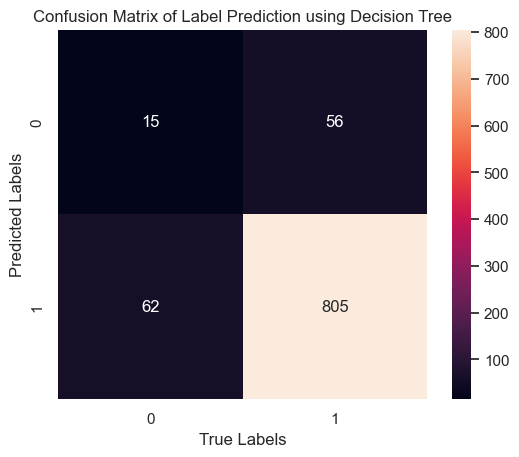

In [18]:
# plot the confusion matrix
dt_mat = confusion_matrix(y_test, dt_y_pred)
dt_tn, dt_fp, dt_fn, dt_tp = confusion_matrix(y_test, dt_y_pred).ravel()

print (f"Overall Accuracy : {dt_acc}")
print (f"True Positives : {dt_tp}")
print (f"True Negatives : {dt_tn}")
print (f"False Positives : {dt_fp}")
print (f"False Negatives : {dt_fn}")

# create a heatmap
sns.heatmap(dt_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using Decision Tree') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### Random Forest

#### Model Testing & Accuracy

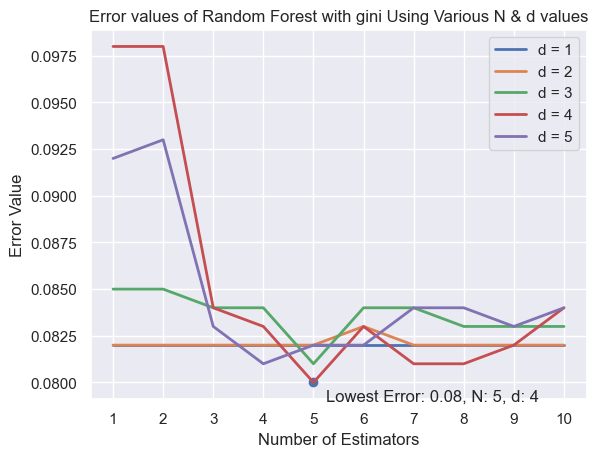

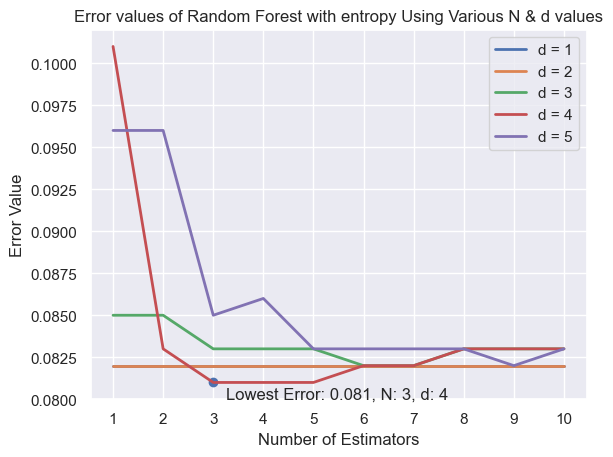

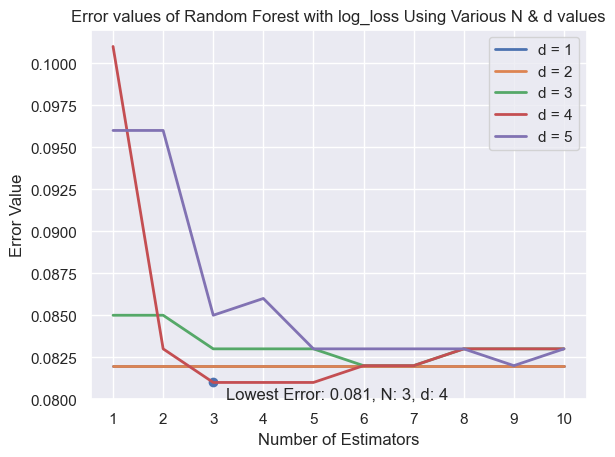

In [19]:
# run a set of error calculations on random forest using various values of N
# number of models and d depth.
from sklearn.ensemble import RandomForestClassifier

# containters for criterion to use as iteration
criterion = ['gini', 'entropy', 'log_loss']

# iterate through criterion
for value in criterion:
    # iterate through splitting strategies

    # empty list for error and model storage
    results = []
    # run loop for all depths ranging 1-5 (1 added within classifier call)
    for d in range(5):

        # create a empty list within list index to store errors & models for d value
        results.append([])

        # run loop for all # of estimators ranging 1-10 (1 added within classifier
        # call)
        for N in range(10):
            # create and fit a random forest model to the training data
            rf_model = RandomForestClassifier(random_state = 1, 
                                              n_estimators =(N+1),
                                              max_depth =(d+1),  
                                              criterion = value)
            rf_model.fit(x_train_sc, y_train)

            # predict class values for x_test
            rf_y_pred = rf_model.predict(x_test_sc)

            # compute error as 1 - accuracy
            error = 1 - accuracy_score(y_test, rf_y_pred)

            # add to storage matrix
            new_entry = {'N': N+1, 'd': d+1, 'Error': round(error, 3),
                         'Model': rf_model, 'Y_pred': rf_y_pred}
            results[d].append(new_entry)

        # graph the results to find lowest error

    plt.title(f"Error values of Random Forest with {value} Using Various " +
              "N & d values")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Error Value")
    plt.xticks(range(1,11))

    # trackers for N, d at lowest error
    N_label, d_label, low_err = 0, 0, 1

    # plot 5 lines related to the 5 depth values
    for d in range(5):

        y_dict = results[d]

        X, Y = [], []
        # track lowest error for isolation and labeling
        for N in range (len(y_dict)):

            # set X and Y point values
            X.append(y_dict[N]['N'])
            Y.append(y_dict[N]['Error'])

            if y_dict[N]['Error'] < low_err:
                low_err = y_dict[N]['Error']
                N_label = y_dict[N]['N']
                d_label = y_dict[N]['d']

        # plot 5 d-lines 
        plt.plot (X, Y, lw = 2, label = f"d = {d+1}")

    # plot point of lowest error and custom label
    plt.scatter(N_label, low_err)
    plt.text(N_label+.25, low_err -.001, 
             f'Lowest Error: {low_err}, N: {N_label}, d: {d_label}')            

    plt.legend()
    plt.show()

The random forest model was tuned using the error comparisons of 'N' ensemble trees from 1 to 10, 'd' depth of trees from 1 to 5, and across splitting criterion 'gini', 'entropy' and log_loss'.  From the three graphs produced, the lowest error came from using the gini criterion with N = 5 and d = 4.  This will be used for the model comparison.

In [20]:
# create and fit a random forest model to the training data
rf_model = RandomForestClassifier(random_state = 1, 
                                  n_estimators =(5),
                                  max_depth =(4),  
                                  criterion = 'gini')
rf_model.fit(x_train_sc, y_train)

# predict class values for x_test
rf_y_pred = rf_model.predict(x_test_sc)

# calculate accuracy and print
print ("Accuracy using Random Forest (gini) class prediction vs actual \n" +
       "(where N = 5 and d = 4) : ")
        
rf_acc = round(accuracy_score(y_test, rf_y_pred), 3)
rf_acc

Accuracy using Random Forest (gini) class prediction vs actual 
(where N = 5 and d = 4) : 


0.92

#### Confusion Matrix

Overall Accuracy : 0.92
True Positives : 861
True Negatives : 2
False Positives : 75
False Negatives : 0


Text(74.45000000000006, 0.5, 'Predicted Labels')

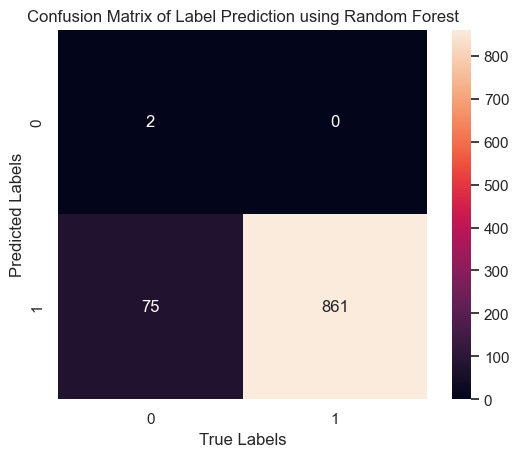

In [21]:
# plot the confusion matrix
rf_mat = confusion_matrix(y_test, rf_y_pred)
rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_test, rf_y_pred).ravel()

print (f"Overall Accuracy : {rf_acc}")
print (f"True Positives : {rf_tp}")
print (f"True Negatives : {rf_tn}")
print (f"False Positives : {rf_fp}")
print (f"False Negatives : {rf_fn}")

# create a heatmap
sns.heatmap(rf_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using Random Forest') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### Support Vector Machines

#### Model Testing & Accuracy

In [22]:
from sklearn.svm import SVC # support vector classification

# containters for kernels to use as iteration
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# container for accuracies
acc_list = []

for value in kernel:

    # begin a linear SVM classifier
    svm = SVC(kernel=value)

    # fit model to data
    svm.fit(x_train_sc, y_train)

    # predict class data with model
    svm_y_pred = svm.predict(x_test_sc)
    
    # calculate accuracy and add to accuracy list
    svm_acc = round(accuracy_score(y_test, svm_y_pred), 3)
    acc_list.append(svm_acc)

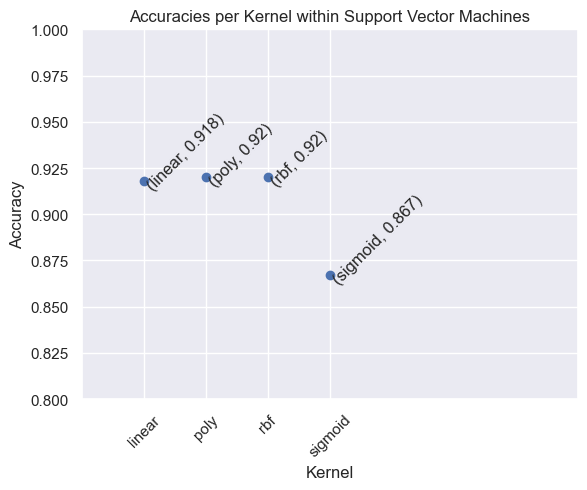

In [36]:
# create x and y data for scatterplot
x = np.array(kernel)
y = np.array(acc_list)

# plot data
plt.scatter(x, y)

# create coordinate outputs beside point
for i, j in zip(x, y):
   plt.text(i, j -.005, '({}, {})'.format(i, j), rotation=45)

# labels and titles
plt.title("Accuracies per Kernel within Support Vector Machines")
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)

# set boundaries and show
plt.axis([-1, 7, .8, 1])
plt.show()

The kernel types for SVM classifiers were compared to determine which provided the best accuracy.  As seen by the accuracy plot, 'poly' and 'rbf' performed the best at 0.92.  Therefore, arbitrarily we will use the default 'rbf'.

In [24]:
# begin a SVM classifier
svm = SVC()

# fit model to data
svm.fit(x_train_sc, y_train)

# predict class data with model
svm_y_pred = svm.predict(x_test_sc)

# calculate accuracy and add to accuracy list
svm_acc = round(accuracy_score(y_test, svm_y_pred), 3)
print (f"Accuracy using SVM on test data is : {svm_acc}")

Accuracy using SVM on test data is : 0.92


Overall Accuracy : 0.92
True Positives : 861
True Negatives : 2
False Positives : 75
False Negatives : 0


Text(74.45000000000006, 0.5, 'Predicted Labels')

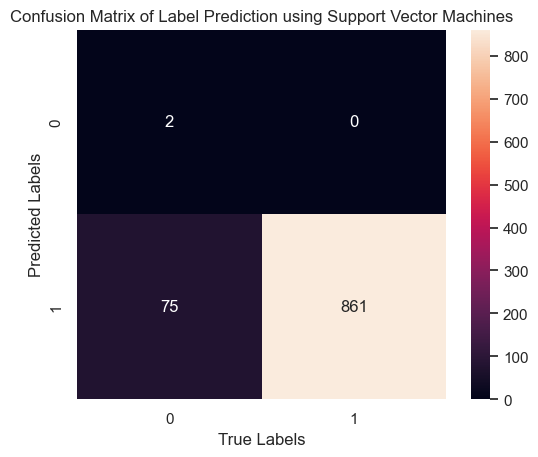

In [25]:
# plot the confusion matrix
svm_mat = confusion_matrix(y_test, svm_y_pred)
svm_tn, svm_fp, svm_fn, svm_tp = confusion_matrix(y_test, svm_y_pred).ravel()

print (f"Overall Accuracy : {svm_acc}")
print (f"True Positives : {svm_tp}")
print (f"True Negatives : {svm_tn}")
print (f"False Positives : {svm_fp}")
print (f"False Negatives : {svm_fn}")

# create a heatmap
sns.heatmap(svm_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using Support Vector Machines') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

### K Means

#### Model Testing & Accuracy

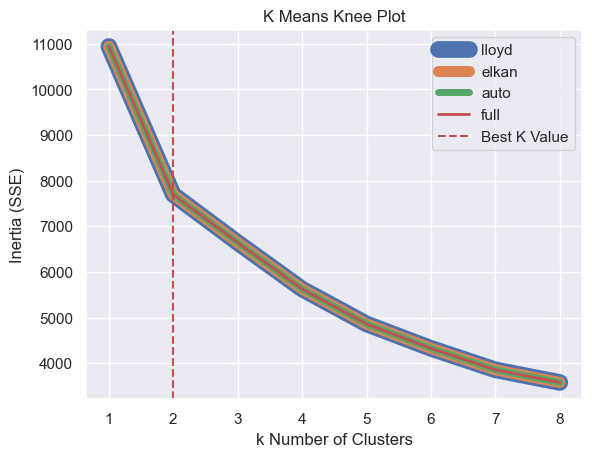

In [26]:
from sklearn.cluster import KMeans

# Ignore warnings due to KMeans memory leaks and default n_init value
import warnings
warnings.filterwarnings('ignore')

# graph the results to find lowest error

plt.title("K Means Knee Plot")
plt.xlabel("k Number of Clusters")
plt.ylabel("Inertia (SSE)")
plt.xticks(range(1,9))

# algorithm container to iterate through algorithms
algorithm = ['lloyd', 'elkan', 'auto', 'full']

# coordinate storage
coords = []

# iterate through algorithms
for value in algorithm:
    # create X and Y coordinate storage
    X, Y = [], []

    for k in range (1,9):
        # create and fit a k-means model to the training data
        # random_state used to make results repeatable
        kmeans = KMeans(n_clusters=k, random_state = 0, 
                        init='random', algorithm=value)
        kmeans.fit(x_train_sc,y_train)

        # predict class values for x_test
        km_y_pred = kmeans.predict(x_test_sc)

        # compute the loss function (SSE)
        SSE = kmeans.inertia_

        # build X,Y coordinates
        X.append(k)
        Y.append(SSE)
    
    # add to coordinate storage
    coords.append(X)
    coords.append(Y)

# plot algorithm results.  Line thickness differences are to demonstrate 
# multiple lines are graphed on top of each other.

plt.plot (coords[0], coords[1], lw = 12, label = 'lloyd')  
plt.plot (coords[2], coords[3], lw = 8, label = 'elkan')   
plt.plot (coords[4], coords[5], lw = 5, label = 'auto')   
plt.plot (coords[6], coords[7], lw = 2, label = 'full')  

# plot estimation of best 'k'
plt.axvline(x=2, color='r', ls = '--', label = 'Best K Value') 
 
plt.legend()
plt.show()

All of the various algorithms for K Means produced near identical knee plots.  There is no discernable difference between the results of their cost functions.  Therefore, any algorithm will do.  Regarding the number of clusters 'k', the sharpest drop is from k = 1 to 2.  Also, as we want the model to predict a possibility of two class labels, we will lock in k = 2 clusters for our model comparison.

In [27]:
# create and fit a k-means model to the training data
# random_state used to make results repeatable
kmeans = KMeans(n_clusters=2, random_state = 0, 
                init='random')
kmeans.fit(x_train_sc,y_train)

# predict class values for x_test
km_y_pred = kmeans.predict(x_test_sc)

# overall accuracy from k-means above
km_acc = round(accuracy_score(km_y_pred, y_test), 3)
print (f"Accuracy using K-means on test data is : {km_acc}")


Accuracy using K-means on test data is : 0.67


#### Confusion Matrix

Overall Accuracy : 0.67
True Positives : 583
True Negatives : 45
False Positives : 32
False Negatives : 278


Text(74.45000000000006, 0.5, 'Predicted Labels')

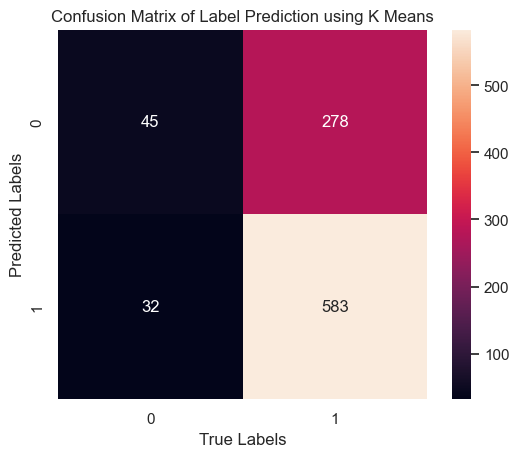

In [28]:
# plot the confusion matrix
km_mat = confusion_matrix(y_test, km_y_pred)
km_tn, km_fp, km_fn, km_tp = confusion_matrix(y_test, km_y_pred).ravel()

print (f"Overall Accuracy : {km_acc}")
print (f"True Positives : {km_tp}")
print (f"True Negatives : {km_tn}")
print (f"False Positives : {km_fp}")
print (f"False Negatives : {km_fn}")

# create a heatmap
sns.heatmap(km_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using K Means') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

## Comparison of Models

In [29]:
# create display dataframe
display = pd.DataFrame (columns = ["TP", "FP", "TN", "FN", "Accuracy",
                                  "TPR", "TNR"],
                          index = ["K Nearest Neighbor", "Logistic Regression",
                                   "Gaussian Naive Bayesian", "Decision Tree",
                                   "Random Forest", "Support Vector Machines",
                                   "K Means"])

# label rows and columns appropriately
display.index.name = "Model"
display.columns.name = "Statistics" 

# import k nearest neighbor model statistics
display.iloc[0, ] = [kn_tp, kn_fp, kn_tn, kn_fn, kn_acc,
                     round (kn_tp / (kn_tp + kn_fn), 3),    # TPR calc
                     round (kn_tn / (kn_tn + kn_fp), 3) ]   # TNR calc

# import logistic regression model statistics
display.iloc[1, ] = [lr_tp, lr_fp, lr_tn, lr_fn, lr_acc,
                     round (lr_tp / (lr_tp + lr_fn), 3),    # TPR calc
                     round (lr_tn / (lr_tn + lr_fp), 3) ]   # TNR calc

# import Gaussian naive bayesian model statistics
display.iloc[2, ] = [nb_tp, nb_fp, nb_tn, nb_fn, nb_acc,
                     round (nb_tp / (nb_tp + nb_fn), 3),    # TPR calc
                     round (nb_tn / (nb_tn + nb_fp), 3) ]   # TNR calc

# import decision tree model statistics
display.iloc[3, ] = [dt_tp, dt_fp, dt_tn, dt_fn, dt_acc,
                     round (dt_tp / (dt_tp + dt_fn), 3),    # TPR calc
                     round (dt_tn / (dt_tn + dt_fp), 3) ]   # TNR calc

# import random forest model statistics
display.iloc[4, ] = [rf_tp, rf_fp, rf_tn, rf_fn, rf_acc,
                     round (rf_tp / (rf_tp + rf_fn), 3),    # TPR calc
                     round (rf_tn / (rf_tn + rf_fp), 3) ]   # TNR calc

# import support vector machines model statistics
display.iloc[5, ] = [svm_tp, svm_fp, svm_tn, svm_fn, svm_acc,
                     round (svm_tp / (svm_tp + svm_fn), 3),    # TPR calc
                     round (svm_tn / (svm_tn + svm_fp), 3) ]   # TNR calc

# import k means model statistics
display.iloc[6, ] = [km_tp, km_fp, km_tn, km_fn, km_acc,
                     round (km_tp / (km_tp + km_fn), 3),    # TPR calc
                     round (km_tn / (km_tn + km_fp), 3) ]   # TNR calc

# print display
display

Statistics,TP,FP,TN,FN,Accuracy,TPR,TNR
Model,,,,,,,
K Nearest Neighbor,852,73,4,9,0.913,0.99,0.052
Logistic Regression,858,74,3,3,0.918,0.997,0.039
Gaussian Naive Bayesian,667,28,49,194,0.763,0.775,0.636
Decision Tree,805,62,15,56,0.874,0.935,0.195
Random Forest,861,75,2,0,0.92,1.0,0.026
Support Vector Machines,861,75,2,0,0.92,1.0,0.026
K Means,583,32,45,278,0.67,0.677,0.584


### Observations
Most Accurate Models
- The most accurate models were Random Forest and Support Vector Machines, which tied at a 0.920 accuracy rating.  Also with high accuracy were Logistic Regression at 0.918 and K Nearest Neighbor at 0.913.
- Unsurprisingly, Random Forest and Support Vector Machines were also the best at guessing true positives, having a perfect TPR.

Least Accurate Models
- K Means performed the worst of the models at 0.670 accuracy, which was most likely influenced by its k=2 cluster assignment and the fact that the actual class data was not evenly weighted. 
- **Note** - K Means here was used as a classifier rather than clustering on the unsupervised unsplit data so as to calculate accuracies on the same scaled test data as the other models.  
- Gaussian Naive Bayes performed only slightly better at 0.763 accuracy.  

Other Observations
- No model had a very good TNR accuracy, possibly because the class label data is more heavily skewed to the positive rather than the negative.

### Creating a Total Ensemble Classifier (TEC)
To see if a combination of all the classifiers is any more accurate than the individuals, a total ensemble can be created by comparing all of the class predictions from the models and performing a majority vote.  

**Note** - As K Means and Gaussian Naive Bayes performed poorly when compared to the other results, the strategic decision was made to omit these models from the total ensemble.

In [30]:
# create a dataframe for visualization of all previous model predictions
all_frame = pd.DataFrame (columns = ['actual', 'KNN', 'LR', 'GNB', 
                                     'DT', 'RF', 'SVM', 'KM'])

all_frame['actual'] = y_test     # actual class labels
all_frame['KNN'] = kn_y_pred     # k nearest neighbor
all_frame['LR'] = lr_y_pred      # logistic regression
all_frame['GNB'] = nb_y_pred     # Gaussian naive bayes
all_frame['DT'] = dt_y_pred      # decision tree
all_frame['RF'] = rf_y_pred      # random forest
all_frame['SVM'] = svm_y_pred    # support vector machines
all_frame['KM'] = km_y_pred      # k means

all_frame


,actual,KNN,LR,GNB,DT,RF,SVM,KM
3028,1,1,1,0,1,1,1,0
1372,1,1,1,1,1,1,1,1
2830,1,1,1,1,1,1,1,1
2067,1,1,1,1,1,1,1,1
2255,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...
2665,1,1,1,1,1,1,1,1
126,1,1,1,1,1,1,1,1
2344,1,1,1,1,1,1,1,1
2062,1,1,1,1,1,1,1,1


In [31]:
# create the ensemble class prediction

# prediction container
tec_y_pred = []

# iterate across all rows
for index in range(len(y_test)):
    
    # with 5 classifiers, the total is odd.  If all classifiers predict 1,
    # then the sum of that row would be 5.  For majority rule, if the sum
    # of a row is 3 or above, the ensemble would predict 1, otherwise 0.
    row_sum = sum(all_frame.iloc [index, [1,2,4,5,6] ])
    
    if row_sum > 2:
        tec_y_pred.append (1)
    else:
        tec_y_pred.append (0)

tec_y_pred = np.array(tec_y_pred)

# plug into results dataframe to compare with the rest
all_frame["ensemble"] = tec_y_pred
all_frame

,actual,KNN,LR,GNB,DT,RF,SVM,KM,ensemble
3028,1,1,1,0,1,1,1,0,1
1372,1,1,1,1,1,1,1,1,1
2830,1,1,1,1,1,1,1,1,1
2067,1,1,1,1,1,1,1,1,1
2255,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2665,1,1,1,1,1,1,1,1,1
126,1,1,1,1,1,1,1,1,1
2344,1,1,1,1,1,1,1,1,1
2062,1,1,1,1,1,1,1,1,1


#### Ensemble Accuracy

In [32]:
# overall accuracy from ensemble above
tec_acc = round(accuracy_score(tec_y_pred, y_test), 3)
print (f"Accuracy using K-means on test data is : {tec_acc}")

Accuracy using K-means on test data is : 0.92


#### Ensemble Confusion Matrix

Overall Accuracy : 0.92
True Positives : 861
True Negatives : 2
False Positives : 75
False Negatives : 0


Text(74.45000000000006, 0.5, 'Predicted Labels')

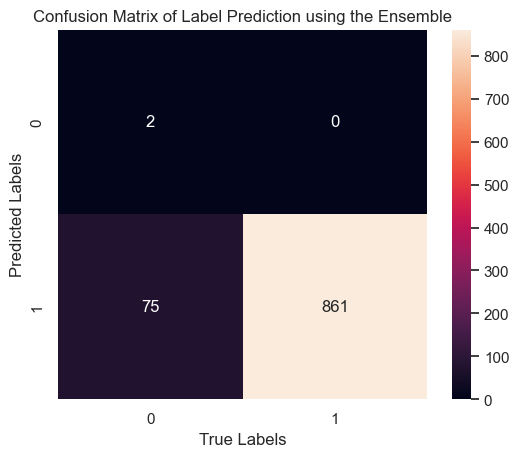

In [33]:
# plot the confusion matrix
tec_mat = confusion_matrix(y_test, tec_y_pred)
tec_tn, tec_fp, tec_fn, tec_tp = confusion_matrix(y_test, tec_y_pred).ravel()

print (f"Overall Accuracy : {tec_acc}")
print (f"True Positives : {tec_tp}")
print (f"True Negatives : {tec_tn}")
print (f"False Positives : {tec_fp}")
print (f"False Negatives : {tec_fn}")

# create a heatmap
sns.heatmap(tec_mat.T, square=True, annot=True, fmt = 'd', cbar=True) 

# label plot
plt.title ('Confusion Matrix of Label Prediction using the Ensemble') 
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

#### Final Comparison

In [34]:
# import ensemble model statistics
display.loc["Ensemble"] = [tec_tp, tec_fp, tec_tn, tec_fn, tec_acc,
                     round (tec_tp / (tec_tp + tec_fn), 3),    # TPR calc
                     round (tec_tn / (tec_tn + tec_fp), 3) ]   # TNR calc

display

Statistics,TP,FP,TN,FN,Accuracy,TPR,TNR
Model,,,,,,,
K Nearest Neighbor,852,73,4,9,0.913,0.99,0.052
Logistic Regression,858,74,3,3,0.918,0.997,0.039
Gaussian Naive Bayesian,667,28,49,194,0.763,0.775,0.636
Decision Tree,805,62,15,56,0.874,0.935,0.195
Random Forest,861,75,2,0,0.92,1.0,0.026
Support Vector Machines,861,75,2,0,0.92,1.0,0.026
K Means,583,32,45,278,0.67,0.677,0.584
Ensemble,861.0,75.0,2.0,0.0,0.92,1.0,0.026


The ensemble model ended up being as accurate as our two most accurate individual models, Random Forest and Support Vector Machines.  

## Predicting Broadband Availability of My Local County

Cumberland County, Pennsylvania

From dataset (referenced 2019 to 2020):

- percentage of people unemployed = 3.4
- percentage without health insurance = 5.8 
- percentage of people in poverty = 7.4
- percentage of people on SNAP = 7.2
- population = 254951 
    

In [35]:
# create Cumberland, PA data
cumberland = np.array([3.4, 5.8, 7.4, 7.2, 254951]).reshape(1, -1)

# scale transform test data
cumberland_sc = scaler.transform(cumberland)

# create a dataframe for visualization of all new model predictions
cumb_frame = pd.DataFrame (columns = ['KNN', 'LR', 'GNB', 
                                     'DT', 'RF', 'SVM', 'KM', 'ensemble'],
                           index = ['Cumberland_PA'])

# column values come from all the respective model predictions
cumb_frame['KNN'] = knn_class.predict(cumberland_sc)
cumb_frame['LR'] = log_reg.predict(cumberland_sc)
cumb_frame['GNB'] = gnb_class.predict(cumberland_sc)
cumb_frame['DT'] = dt_model.predict(cumberland_sc)
cumb_frame['RF'] = rf_model.predict(cumberland_sc)
cumb_frame['SVM'] = svm.predict(cumberland_sc)
cumb_frame['KM'] = kmeans.predict(cumberland_sc)

# ensemble is a sum analysis of the top 5 performing models above
row_sum = sum(cumb_frame.iloc [0, [0,1,3,4,5] ])
    
if row_sum > 2:
    cumb_frame['ensemble'] = 1
else:
    cumb_frame['ensemble'] = 0

cumb_frame

,KNN,LR,GNB,DT,RF,SVM,KM,ensemble
Cumberland_PA,1,1,1,1,1,1,1,1


All models predict that Cumberland, PA has broadband access based on its census-based dependent variables.